<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Scraping, NLP and Binary Classification Problem

# Objective of the project:
    
* Use Pushshift API to collect 2 subreddits category: makeup and fragrance
* Use NLP to train a classifier on which subreddit a post has been given to

In this notebook, I will be doing EDA for both Makeup Subreddit and Fragrance Subreddit.


In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import regex as re
import time


pd.set_option('display.max_columns', None)
from matplotlib_venn import venn2
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
from nltk.corpus import stopwords 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [2]:
#read makeup csv
df_makeup = pd.read_csv('Makeup.csv')

#read fragrance csv
df_fragrance = pd.read_csv('fragrance.csv')

In [3]:
print(f'No. of Makeup Datasets : {len(df_makeup)}')
print(f'Shape of Makeup Datasets : {df_makeup.shape}')
print("")
print(f'No. of Fragrance Datasets : {len(df_fragrance)}')
print(f'Shape of Fragrance Datasets : {df_fragrance.shape}')

No. of Makeup Datasets : 1100
Shape of Makeup Datasets : (1100, 77)

No. of Fragrance Datasets : 1100
Shape of Fragrance Datasets : (1100, 74)


# Makeup Subreddit

In [4]:
df_makeup.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,link_flair_template_id,link_flair_text,post_hint,preview,removed_by_category,crosspost_parent,crosspost_parent_list,url_overridden_by_dest,author_cakeday,thumbnail_height,thumbnail_width,edited,author_flair_background_color,author_flair_text_color,author_flair_template_id,banned_by
0,0,[],False,ChristyR4230,NaN,[],NaN,text,t2_3944zu0n,False,False,False,[],False,False,1630128972,self.Makeup,https://www.reddit.com/r/Makeup/comments/pd43e...,{},pd43e6,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/Makeup/comments/pd43e6/gel_eyeliner_gets_re...,False,6,1630128983,1,"hey, I’m fairly new to makeup.., whenever i we...",True,False,False,Makeup,t5_2qrwc,443317,public,top,self,gel eyeliner gets really messy,0,[],1.0,https://www.reddit.com/r/Makeup/comments/pd43e...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,ASOMA-59,NaN,[],NaN,text,t2_e4j1ejyk,False,False,False,[],False,False,1630127955,self.Makeup,https://www.reddit.com/r/Makeup/comments/pd3vw...,{},pd3vwc,False,False,False,False,False,False,True,False,NaN,"[{'e': 'text', 't': '[Makeup Help]'}]",dark,richtext,False,False,True,0,0,False,all_ads,/r/Makeup/comments/pd3vwc/which_is_the_best_br...,False,6,1630127966,1,[removed],True,False,False,Makeup,t5_2qrwc,443312,public,top,self,Which Is The Best Brand For Makeup Kit?,0,[],1.0,https://www.reddit.com/r/Makeup/comments/pd3vw...,all_ads,6,0eb429a6-3b52-11e3-ad3c-12313d184137,[Makeup Help],self,"{'enabled': False, 'images': [{'id': '_xv6KQEg...",reddit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,Asmodaia,NaN,[],NaN,text,t2_dp629h8g,False,False,False,[],False,False,1630126704,self.Makeup,https://www.reddit.com/r/Makeup/comments/pd3ma...,{},pd3mad,False,True,False,False,False,True,True,False,NaN,"[{'e': 'text', 't': '[Makeup Help]'}]",dark,richtext,False,False,True,0,0,False,all_ads,/r/Makeup/comments/pd3mad/colorfix/,False,6,1630126714,1,Has anybody tried Danessa Myricks' Colorfix? I...,True,False,False,Makeup,t5_2qrwc,443307,public,top,self,Colorfix?,0,[],1.0,https://www.reddit.com/r/Makeup/comments/pd3ma...,all_ads,6,0eb429a6-3b52-11e3-ad3c-12313d184137,[Makeup Help],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,21446,NaN,[],NaN,text,t2_6by954v6,False,False,False,[],False,False,1630123910,self.Makeup,https://www.reddit.com/r/Makeup/comments/pd2zy...,{},pd2zyz,False,True,False,False,False,True,True,False,NaN,"[{'e': 'text', 't': '[Makeup Help]'}]",dark,richtext,False,False,True,0,0,False,all_ads,/r/Makeup/comments/pd2zyz/are_all_micellar_wat...,False,6,1630123921,1,My main goal is to use micellar water as an ey...,True,False,False,Makeup,t5_2qrwc,443294,public,top,self,Are all micellar water products the same? How ...,0,[],1.0,https://www.reddit.com/r/Makeup/comments/pd2zy...,all_ads,6,0eb429a6-3b52-11e3-ad3c-12313d184137,[Makeup Help],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,melissajackson07,NaN,[],NaN,text,t2_1pqcatke,False,False,False,[],False,False,1630122169,self.Makeup,https://www.reddit.com/r/Makeup/comments/pd2l1...,{},pd2l1k,False,True,False,False,False,True,True

In [5]:
df_makeup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 77 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1100 non-null   int64  
 1   all_awardings                  1100 non-null   object 
 2   allow_live_comments            1100 non-null   bool   
 3   author                         1100 non-null   object 
 4   author_flair_css_class         0 non-null      float64
 5   author_flair_richtext          1098 non-null   object 
 6   author_flair_text              2 non-null      object 
 7   author_flair_type              1098 non-null   object 
 8   author_fullname                1098 non-null   object 
 9   author_is_blocked              977 non-null    object 
 10  author_patreon_flair           1098 non-null   object 
 11  author_premium                 1098 non-null   object 
 12  awarders                       1100 non-null   o

In [6]:
#function to convert the created utc to datetime
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [7]:
#selecting the columns that is necessary 
df_makeup = df_makeup[['title' , 'subreddit', 'created_utc','selftext']]
df_makeup = date_conversion(df_makeup, 'created_utc')

In [8]:
#checking the info of df_makeup
df_makeup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        1100 non-null   object        
 1   subreddit    1100 non-null   object        
 2   created_utc  1100 non-null   datetime64[ns]
 3   selftext     1038 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 34.5+ KB


In [9]:
#check for null 
df_makeup.isnull().sum()

title           0
subreddit       0
created_utc     0
selftext       62
dtype: int64

Selftext has 62 null values. as it is a small number compared to total of 1100 entries, lets drop the rows that has null


In [10]:
#check for duplicates
df_makeup.duplicated().sum()

0

In [11]:
#drop the null values
df_makeup.dropna(inplace = True)

In [12]:
#checking for null value
df_makeup.isnull().sum()

title          0
subreddit      0
created_utc    0
selftext       0
dtype: int64

In [13]:
#check for info
df_makeup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1099
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        1038 non-null   object        
 1   subreddit    1038 non-null   object        
 2   created_utc  1038 non-null   datetime64[ns]
 3   selftext     1038 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 40.5+ KB


In [14]:
print(df_makeup.created_utc.max())
print(df_makeup.created_utc.min())

2021-08-28 13:36:12
2021-07-18 04:01:48


* Makeup subreddit is pretty active subreddit as it has over 1000 posts for a duration of 1 month
* Null values are small (62 out of total 1100), hence I have decided to drop the rows that has null values


# Fragrance Subreddit

In [15]:
#check 1st 5 rows
df_fragrance.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,removed_by_category,post_hint,preview,poll_data,author_flair_background_color,author_flair_template_id,author_flair_text_color,banned_by,edited,author_cakeday
0,0,[],False,Nikko_Kuzma,NaN,[],NaN,text,t2_dkyxctf5,False,False,False,[],False,False,1630136321,self.fragrance,https://www.reddit.com/r/fragrance/comments/pd...,{},pd5jl9,False,True,False,False,False,True,True,False,NaN,Discussion,[],7a10d448-1289-11e8-b97a-0e700fc24c66,Discussion,dark,text,False,False,True,0,0,False,all_ads,/r/fragrance/comments/pd5jl9/valentino_uomo_in...,False,6,1630136332,1,How many sprays of this fragrance do you use a...,True,False,False,fragrance,t5_2sda0,165414,public,top,self,Valentino uomo intense edp,0,[],1.0,https://www.reddit.com/r/fragrance/comments/pd...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,xxyyzzoe,NaN,[],NaN,text,t2_159m0v,False,False,False,[],False,False,1630127506,self.fragrance,https://www.reddit.com/r/fragrance/comments/pd...,{},pd3sln,False,True,False,False,False,True,True,False,NaN,Clones-Dupes,[],5bb44804-b13d-11ea-b195-0e2dec85bc9f,Clones &amp; Dupes,dark,text,False,False,True,0,0,False,all_ads,/r/fragrance/comments/pd3sln/drybar_noir_scent/,False,6,1630127517,1,i am OBSESSED with the smell of drybar hair pr...,True,False,False,fragrance,t5_2sda0,165393,public,top,self,drybar noir scent?,0,[],1.0,https://www.reddit.com/r/fragrance/comments/pd...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,Claphamtulip,NaN,[],NaN,text,t2_u4kdr,False,False,False,[],False,False,1630127317,self.fragrance,https://www.reddit.com/r/fragrance/comments/pd...,{},pd3r6f,False,True,False,False,False,True,True,False,NaN,NaN,[],f8589e0a-1b08-11eb-bd13-0e4ed22876f5,Longevity-Sillage-Projection,dark,text,False,False,True,0,0,False,all_ads,/r/fragrance/comments/pd3r6f/what_longevity_do...,False,6,1630127328,1,My perfumes with the best longevity are Bewitc...,True,False,False,fragrance,t5_2sda0,165392,public,top,self,What longevity do you expect from your perfumes?,0,[],1.0,https://www.reddit.com/r/fragrance/comments/pd...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,venusstar98,NaN,[],NaN,text,t2_dvcb8zco,False,False,False,[],False,False,1630126013,self.fragrance,https://www.reddit.com/r/fragrance/comments/pd...,{},pd3h40,False,False,False,False,False,False,True,False,NaN,Discussion,[],7a10d448-1289-11e8-b97a-0e700fc24c66,Discussion,dark,text,False,False,True,0,0,False,all_ads,/r/fragrance/comments/pd3h40/perfume_reccomend...,False,6,1630126024,1,[removed],True,False,False,fragrance,t5_2sda0,165388,public,top,self,Perfume Reccomendations?,0,[],1.0,https://www.reddit.com/r/fragrance/comments/pd...,all_ads,6,reddit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,therealmisslacreevy,NaN,[],NaN,text,t2_5rtsazmf,False,False,False,[],False,False,1630125832,self.fragrance,https://www.reddit.com/r/fragrance/comments/pd...,{},pd3fop,False,False,False,False,False,False,True,False,NaN,Show-and-Tell-Weekend,[],2476cda8-3f0a-11ea-bba4-0e85ba827d11,Show &amp; Tell Weekend,dark,text,False,False,True,0,0,False,all_ads,/r/fragrance/comments/pd3fo

In [16]:
#check info
df_fragrance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 74 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1100 non-null   int64  
 1   all_awardings                  1100 non-null   object 
 2   allow_live_comments            1100 non-null   bool   
 3   author                         1100 non-null   object 
 4   author_flair_css_class         29 non-null     object 
 5   author_flair_richtext          1081 non-null   object 
 6   author_flair_text              29 non-null     object 
 7   author_flair_type              1081 non-null   object 
 8   author_fullname                1081 non-null   object 
 9   author_is_blocked              1100 non-null   bool   
 10  author_patreon_flair           1081 non-null   object 
 11  author_premium                 1081 non-null   object 
 12  awarders                       1100 non-null   o

In [17]:
#selecting the columns needed and converting the created utc to a datetime
df_fragrance = df_fragrance[['title' , 'subreddit' , 'created_utc', 'selftext']]
df_fragrance = date_conversion(df_fragrance , 'created_utc')

In [18]:
#checking for info
df_fragrance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        1100 non-null   object        
 1   subreddit    1100 non-null   object        
 2   created_utc  1100 non-null   datetime64[ns]
 3   selftext     1088 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 34.5+ KB


In [19]:
#checking for null values
df_fragrance.isnull().sum()

title           0
subreddit       0
created_utc     0
selftext       12
dtype: int64

selftext has 12 null values out of total 1100 posts. As it is a very small percentage of about 1%, I will drop the null values

In [20]:
#check for duplicates
df_fragrance.duplicated().sum()

2

In [21]:
#drop null values and duplicates
df_fragrance.dropna(inplace=True)
df_fragrance.drop_duplicates(inplace=True)

In [22]:
#check for info
df_fragrance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086 entries, 0 to 1099
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        1086 non-null   object        
 1   subreddit    1086 non-null   object        
 2   created_utc  1086 non-null   datetime64[ns]
 3   selftext     1086 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 42.4+ KB


In [23]:
#see the max and min date and time
print(df_fragrance.created_utc.max())
print(df_fragrance.created_utc.min())

2021-08-28 15:38:41
2021-08-12 00:48:40


* Fragrance subreddit is pretty active subreddit as it has over 1000 posts for a duration of 1 month
* Null values are small (12 out of total 1100), hence I have decided to drop the rows that has null values

# Percentage of text posts

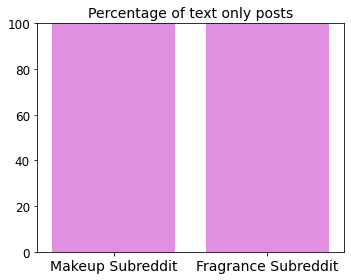

In [24]:
frag_notnull = df_fragrance.notnull().sum()['selftext']/df_fragrance.shape[0] * 100
mkup_notnull = df_makeup.notnull().sum()['selftext']/df_makeup.shape[0] * 100

plt.figure(figsize = (5,4))
sns.barplot(y = [mkup_notnull, frag_notnull], x = ['Makeup Subreddit','Fragrance Subreddit'] , color = 'violet')
plt.title('Percentage of text only posts', fontsize=14)
plt.ylim(0,100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()

Both subreddits are 100% full of texts which is good as we will need text to be able to classify using our models

# Title Content

In [25]:
def topwords_vis(df1 , df2):
    
    fit , ax = plt.subplots(1,2, figsize = (15,10) , sharex = True,constrained_layout=True)
    
    df1.plot(kind = 'barh' , ax = ax[0], color = 'lightcoral' )
    ax[0].set_title('Top Phrases in Makeup Subreddit' , fontsize = 14)
    ax[0].set_xlabel('count of words/phrases', fontsize=13);
    
    df2.plot(kind = 'barh' , ax = ax[1] , color = 'plum')
    ax[1].set_title('Top Phrases in Fragrance Subreddit' , fontsize = 14)
    ax[1].set_xlabel('count of words/phrases', fontsize=13);

In [26]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

#fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_m = cvec.fit_transform(df_makeup['title'])
vec_m = pd.DataFrame(vec_m.toarray(), columns = cvec.get_feature_names())
m_title_50 = vec_m.sum().sort_values(ascending=False).head(50)

# fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_f = cvec.fit_transform(df_fragrance['title'])
vec_f = pd.DataFrame(vec_f.toarray(), columns = cvec.get_feature_names())
f_title_50 = vec_f.sum().sort_values(ascending=False).head(50)

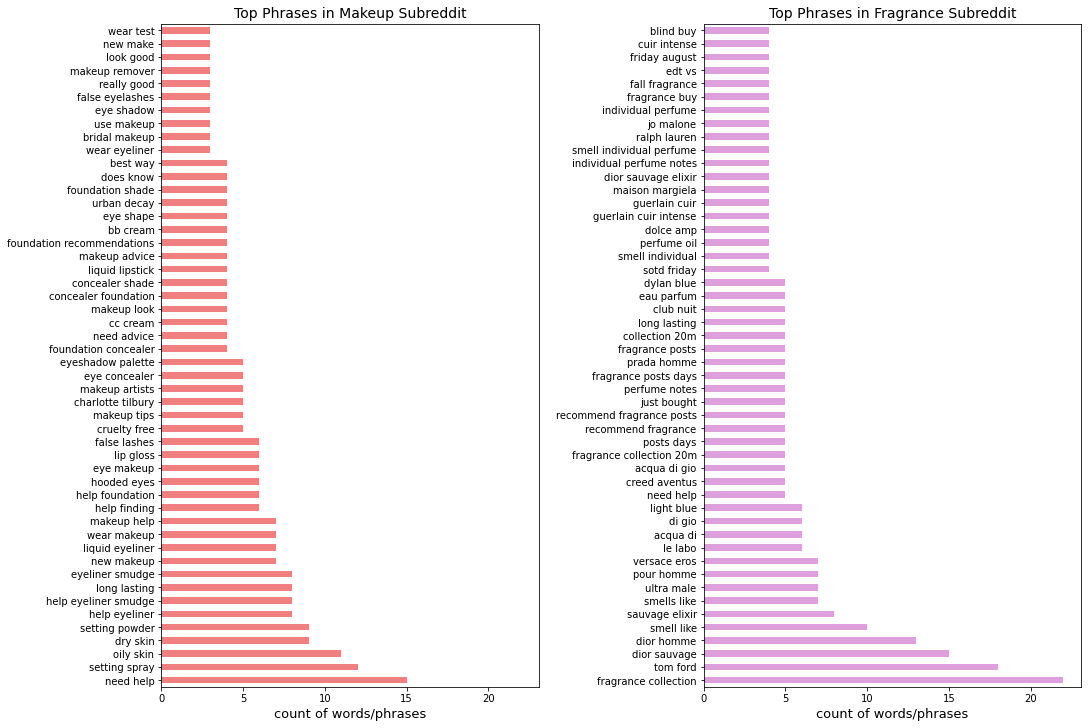

In [27]:
topwords_vis(m_title_50,f_title_50)

# Selftext Content

In [28]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

#fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_m = cvec.fit_transform(df_makeup['selftext'])
vec_m = pd.DataFrame(vec_m.toarray(), columns = cvec.get_feature_names())
m_selftext_50 = vec_m.sum().sort_values(ascending=False).head(50)

# fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_f = cvec.fit_transform(df_fragrance['selftext'])
vec_f = pd.DataFrame(vec_f.toarray(), columns = cvec.get_feature_names())
f_selftext_50 = vec_f.sum().sort_values(ascending=False).head(50)

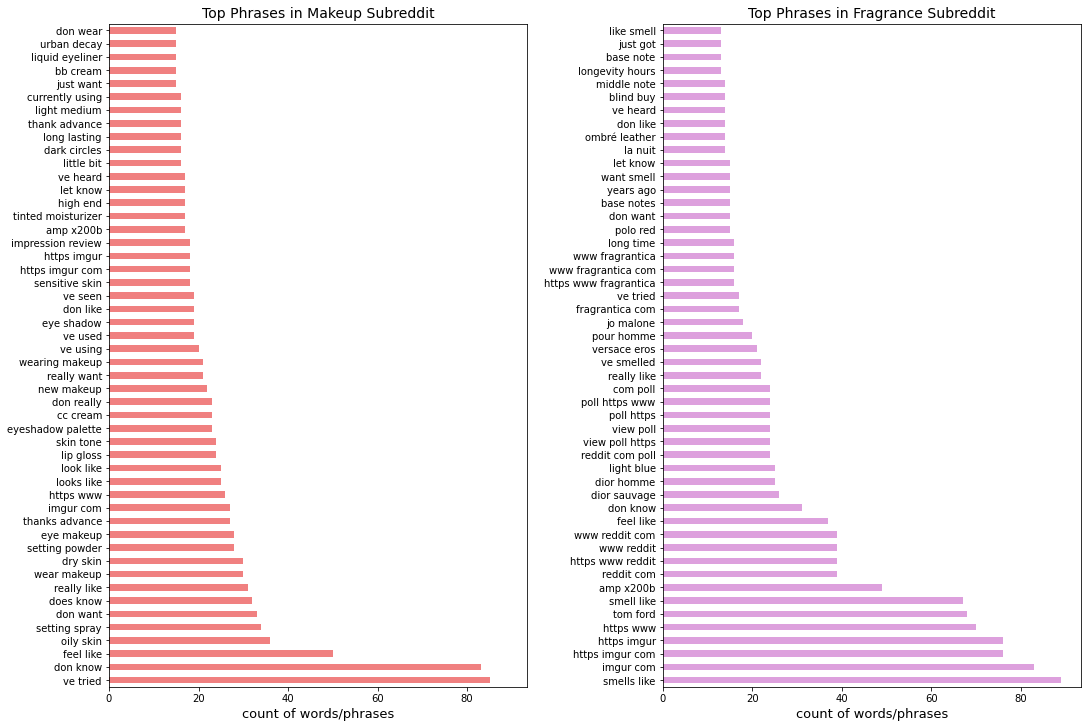

In [29]:
topwords_vis(m_selftext_50,f_selftext_50)

# Exploring Makeup 

In [30]:
#checking 1st 5 rows
df_makeup.head()

,title,subreddit,created_utc,selftext
0,gel eyeliner gets really messy,Makeup,2021-08-28 13:36:12,"hey, I’m fairly new to makeup.., whenever i we..."
1,Which Is The Best Brand For Makeup Kit?,Makeup,2021-08-28 13:19:15,[removed]
2,Colorfix?,Makeup,2021-08-28 12:58:24,Has anybody tried Danessa Myricks' Colorfix? I...
3,Are all micellar water products the same? How ...,Makeup,2021-08-28 12:11:50,My main goal is to use micellar water as an ey...
4,First Impression Reviews,Makeup,2021-08-28 11:42:49,"[Pictures are available on my profile, if inte..."


In [31]:
#combining title and selftect into a new column called message
df_makeup["message"] = df_makeup["title"] + df_makeup["selftext"]

In [32]:
#drop the rows that are not needed anymore
df_makeup.drop(['title','created_utc','selftext'], axis =1, inplace = True)

In [33]:
#double checking the top 5 rows
df_makeup.head()

,subreddit,message
0,Makeup,"gel eyeliner gets really messyhey, I’m fairly ..."
1,Makeup,Which Is The Best Brand For Makeup Kit?[removed]
2,Makeup,Colorfix?Has anybody tried Danessa Myricks' Co...
3,Makeup,Are all micellar water products the same? How ...
4,Makeup,First Impression Reviews[Pictures are availabl...


In [34]:
# Instantiate tokenizer.
tokenizer = RegexpTokenizer(r"\w+[a-zA-Z]")
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()
# Instantiate PorterStemmer.
p_stemmer = PorterStemmer()
# Instantiate Stopwords
stopwords = stopwords.words('english')

In [35]:
#Tokenize and store
df_makeup["tokens"] = df_makeup["message"].apply(tokenizer.tokenize)

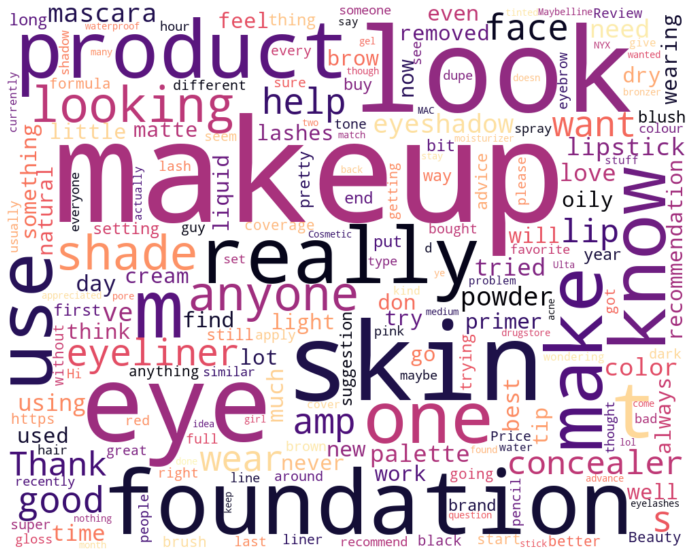

In [36]:
#wordcloud for the tokens using tokenizer
word_all = ' '.join([word for word in df_makeup['message']])
wordcloud = WordCloud(width= 1000, 
                      height= 800,
                      max_font_size = 210,
                      collocations = False,
                      background_color = 'white',
                      colormap= 'magma').generate(word_all)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
#Creating a Lemmatized column

lem_array = []
for i in df_makeup.index:
    lem_list = []
    for x in df_makeup["tokens"][i]:
        lem_list.append(lemmatizer.lemmatize(x).lower())
    lem_array.append(lem_list)

df_makeup['lem'] = lem_array

#Creating a Stemmatized column

stem_array = []
for c in df_makeup.index:
    stem_list = []
    for w in df_makeup["tokens"][c]:
        stem_list.append(p_stemmer.stem(w).lower())
    stem_array.append(stem_list)

df_makeup['stem'] = stem_array

In [38]:
#Comparing Stemmatized and Lemmatized Tokens

list(zip(df_makeup['stem'][0], df_makeup['lem'][0]))

[('gel', 'gel'),
 ('eyelin', 'eyeliner'),
 ('get', 'get'),
 ('realli', 'really'),
 ('messyhey', 'messyhey'),
 ('fairli', 'fairly'),
 ('new', 'new'),
 ('to', 'to'),
 ('makeup', 'makeup'),
 ('whenev', 'whenever'),
 ('wear', 'wear'),
 ('gel', 'gel'),
 ('eyelin', 'eyeliner'),
 ('on', 'on'),
 ('my', 'my'),
 ('waterlin', 'waterline'),
 ('it', 'it'),
 ('give', 'give'),
 ('my', 'my'),
 ('raccoon', 'raccoon'),
 ('eye', 'eye'),
 ('after', 'after'),
 ('while', 'while'),
 ('get', 'get'),
 ('everywher', 'everywhere'),
 ('under', 'under'),
 ('my', 'my'),
 ('eye', 'eye'),
 ('ani', 'any'),
 ('tip', 'tip'),
 ('have', 'have'),
 ('the', 'the'),
 ('nyx', 'nyx'),
 ('gel', 'gel'),
 ('eyelin', 'eyeliner'),
 ('and', 'and'),
 ('wet', 'wet'),
 ('wild', 'wild'),
 ('breakup', 'breakup'),
 ('proof', 'proof'),
 ('will', 'willing'),
 ('to', 'to'),
 ('buy', 'buy'),
 ('suggest', 'suggestion'),
 ('thank', 'thanks')]

In [39]:
#Finding odd words out
comparison = set(df_makeup['stem'][0]) - set(df_makeup['lem'][0])
print(comparison)

{'realli', 'suggest', 'whenev', 'fairli', 'eyelin', 'thank', 'ani', 'waterlin', 'will', 'everywher'}


In [40]:
# Drop Stemmed Columns as the word comes out weird
df_makeup.drop('stem',axis = 1, inplace = True)

In [41]:
#Creating a combined list of words through all elements
freq_count = []

for i in df_makeup['lem']:
    no_stop_words = [token for token in i if token not in stopwords]
    for x in no_stop_words:
        freq_count.append(x)

In [42]:
#Finding words with highest frequency
word_freq = FreqDist(freq_count)
print(word_freq.most_common(15))

[('makeup', 830), ('like', 551), ('look', 534), ('skin', 450), ('eye', 437), ('foundation', 424), ('product', 342), ('really', 331), ('make', 328), ('know', 323), ('would', 317), ('use', 312), ('one', 288), ('get', 275), ('looking', 266)]


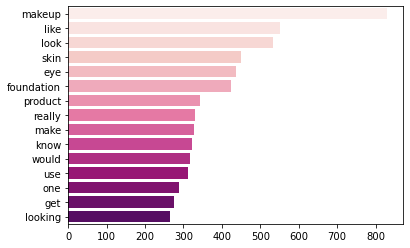

In [43]:
#Top 15 words
makeup_top_fifteen = word_freq.most_common(15)
words_makeup= [x[0] for x in makeup_top_fifteen]
count_makeup= [x[1] for x in makeup_top_fifteen]

sns.barplot(x =count_makeup, y =words_makeup, palette= 'RdPu');

In [44]:
#Adding words into the stopword
new_words = ('wa','one',
             'removed','would','ha',
             'http','hello','hi','http','https')
for i in new_words:
    stopwords.append(i)

### Word Frequency for Makeup

In [45]:
#Creating a combined list of words through all elements
freqm_count = []

for i in df_makeup['lem']:
    no_stop_words = [token for token in i if token not in stopwords]
    for x in no_stop_words:
        freqm_count.append(x)

In [46]:
#Finding words with highest frequency
mword_freq = FreqDist(freq_count)
print(mword_freq.most_common(10))

[('makeup', 830), ('like', 551), ('look', 534), ('skin', 450), ('eye', 437), ('foundation', 424), ('product', 342), ('really', 331), ('make', 328), ('know', 323)]


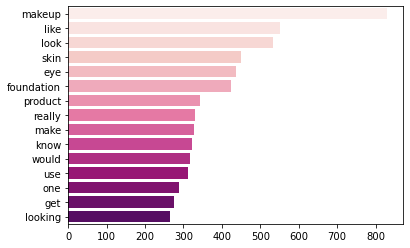

In [47]:
#Top 15 words
makeup_top_fifteen = mword_freq.most_common(15)
words_makeup= [x[0] for x in makeup_top_fifteen]
count_makeup= [x[1] for x in makeup_top_fifteen]

sns.barplot(x =count_makeup, y =words_makeup, palette= 'RdPu');

# Exploring Fragrance

In [48]:
#checking the 1st 5 rows 
df_fragrance.head()

,title,subreddit,created_utc,selftext
0,Valentino uomo intense edp,fragrance,2021-08-28 15:38:41,How many sprays of this fragrance do you use a...
1,drybar noir scent?,fragrance,2021-08-28 13:11:46,i am OBSESSED with the smell of drybar hair pr...
2,What longevity do you expect from your perfumes?,fragrance,2021-08-28 13:08:37,My perfumes with the best longevity are Bewitc...
3,Perfume Reccomendations?,fragrance,2021-08-28 12:46:53,[removed]
4,Fragrance Wardrobe (36F),fragrance,2021-08-28 12:43:52,[removed]


In [49]:
#combining title and selftext into a new column called message
df_fragrance["message"] = df_fragrance["title"] + df_fragrance["selftext"]

In [50]:
#dropping columns that are not needed
df_fragrance.drop(['title','created_utc','selftext'], axis =1, inplace = True)

In [51]:
#checking the 1st 5 rows
df_fragrance.head()

,subreddit,message
0,fragrance,Valentino uomo intense edpHow many sprays of t...
1,fragrance,drybar noir scent?i am OBSESSED with the smell...
2,fragrance,What longevity do you expect from your perfume...
3,fragrance,Perfume Reccomendations?[removed]
4,fragrance,Fragrance Wardrobe (36F)[removed]


In [52]:
#Tokenize and store
df_fragrance["tokens"] = df_fragrance["message"].apply(tokenizer.tokenize)

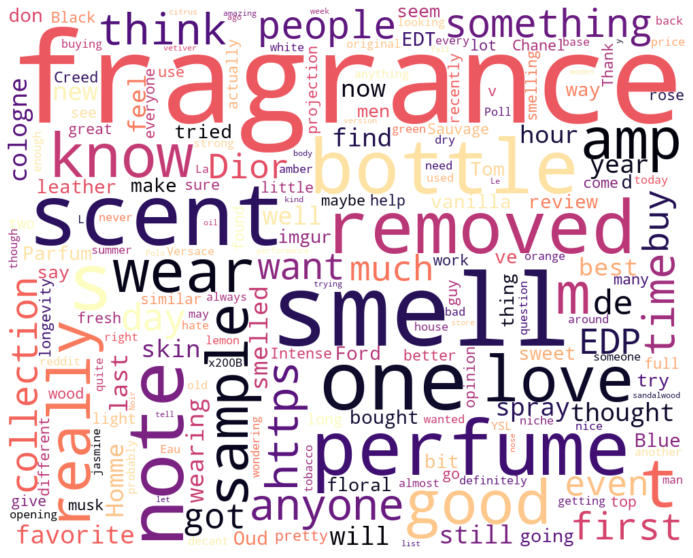

In [53]:
#create a wordcloud for message column
word_all = ' '.join([word for word in df_fragrance['message']])
wordcloud = WordCloud(width= 1000, 
                      height= 800,
                      max_font_size = 210,
                      collocations = False,
                      background_color = 'white',
                      colormap= 'magma').generate(word_all)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [54]:
#Creating a Lemmatized column

lem_array = []
for i in df_fragrance.index:
    lem_list = []
    for x in df_fragrance["tokens"][i]:
        lem_list.append(lemmatizer.lemmatize(x).lower())
    lem_array.append(lem_list)

df_fragrance['lem'] = lem_array

#Creating a Stemmatized column

stem_array = []
for c in df_fragrance.index:
    stem_list = []
    for w in df_fragrance["tokens"][c]:
        stem_list.append(p_stemmer.stem(w).lower())
    stem_array.append(stem_list)

df_fragrance['stem'] = stem_array

In [55]:
#Comparing Stemmatized and Lemmatized Tokens

list(zip(df_fragrance['stem'][0], df_fragrance['lem'][0]))

[('valentino', 'valentino'),
 ('uomo', 'uomo'),
 ('intens', 'intense'),
 ('edphow', 'edphow'),
 ('mani', 'many'),
 ('spray', 'spray'),
 ('of', 'of'),
 ('thi', 'this'),
 ('fragranc', 'fragrance'),
 ('do', 'do'),
 ('you', 'you'),
 ('use', 'use'),
 ('and', 'and'),
 ('is', 'is'),
 ('it', 'it'),
 ('onli', 'only'),
 ('me', 'me'),
 ('or', 'or'),
 ('doe', 'doe'),
 ('it', 'it'),
 ('have', 'have'),
 ('veri', 'very'),
 ('weak', 'weak'),
 ('project', 'projection')]

In [56]:
#Finding odd words out
comparison1 = set(df_fragrance['stem'][0]) - set(df_fragrance['lem'][0])
print(comparison1)

{'project', 'onli', 'mani', 'intens', 'fragranc', 'thi', 'veri'}


In [57]:
# Drop Stemmed Columns as the results do not make sense
df_fragrance.drop('stem',axis = 1, inplace = True)

### Word Frequency for Fragrance

In [58]:
#Creating a combined list of words through all elements
freqf_count = []

for i in df_fragrance['lem']:
    no_stop_words = [token for token in i if token not in stopwords]
    for x in no_stop_words:
        freqf_count.append(x)

In [59]:
#Finding words with highest frequency
fword_freq = FreqDist(freqf_count)
print(fword_freq.most_common(10))

[('fragrance', 993), ('like', 707), ('smell', 600), ('scent', 430), ('note', 333), ('perfume', 328), ('bottle', 327), ('love', 235), ('get', 228), ('good', 219)]


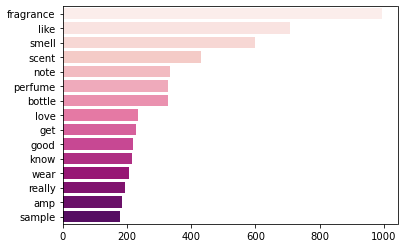

In [60]:
#Top 15 words
frag_top_fifteen = fword_freq.most_common(15)
words_frag= [x[0] for x in frag_top_fifteen]
count_frag= [x[1] for x in frag_top_fifteen]

sns.barplot(x =count_frag, y =words_frag, palette= 'RdPu');

In [61]:
#checking the 1st 5 rows
df_fragrance.head()

,subreddit,message,tokens,lem
0,fragrance,Valentino uomo intense edpHow many sprays of t...,"[Valentino, uomo, intense, edpHow, many, spray...","[valentino, uomo, intense, edphow, many, spray..."
1,fragrance,drybar noir scent?i am OBSESSED with the smell...,"[drybar, noir, scent, am, OBSESSED, with, the,...","[drybar, noir, scent, am, obsessed, with, the,..."
2,fragrance,What longevity do you expect from your perfume...,"[What, longevity, do, you, expect, from, your,...","[what, longevity, do, you, expect, from, your,..."
3,fragrance,Perfume Reccomendations?[removed],"[Perfume, Reccomendations, removed]","[perfume, reccomendations, removed]"
4,fragrance,Fragrance Wardrobe (36F)[removed],"[Fragrance, Wardrobe, 36F, removed]","[fragrance, wardrobe, 36f, removed]"


# Comparing both Fragrance and Makeup Subreddit

In [62]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

#fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_m1 = cvec.fit_transform(df_makeup['message'])
vec_m1 = pd.DataFrame(vec_m1.toarray(), columns = cvec.get_feature_names())
m_message_50 = vec_m1.sum().sort_values(ascending=False).head(50)

# fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_f1 = cvec.fit_transform(df_fragrance['message'])
vec_f1 = pd.DataFrame(vec_f1.toarray(), columns = cvec.get_feature_names())
f_message_50 = vec_f1.sum().sort_values(ascending=False).head(50)

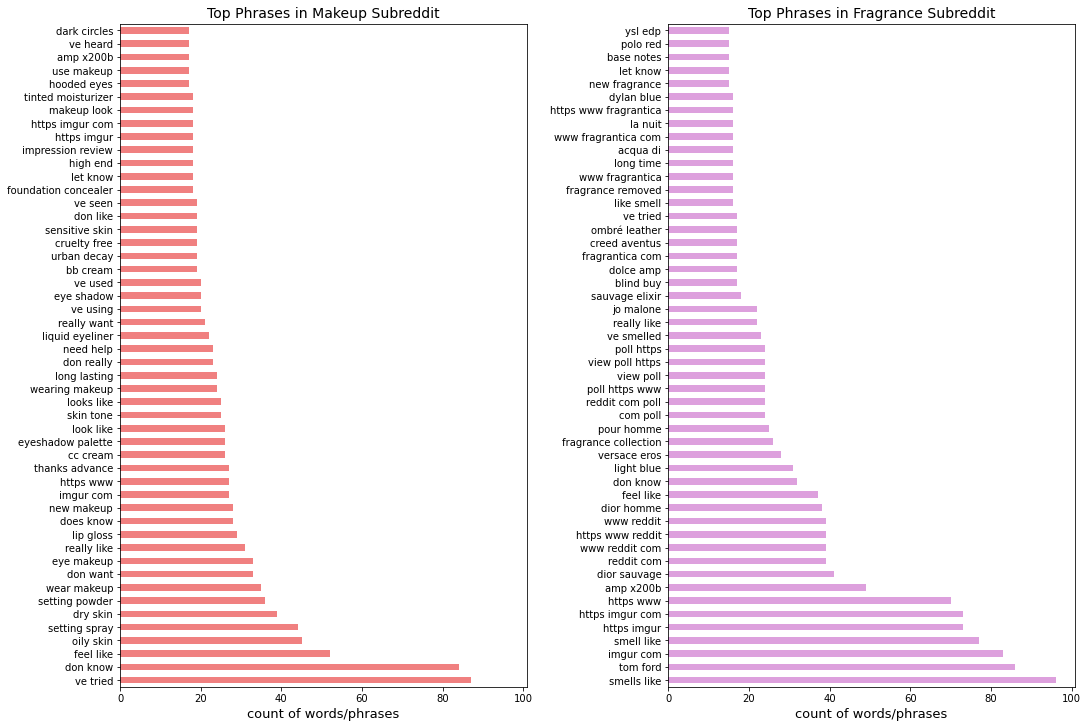

In [63]:
#use the topwords_vis function to create the visualisation for the combined message column
topwords_vis(m_message_50,f_message_50)

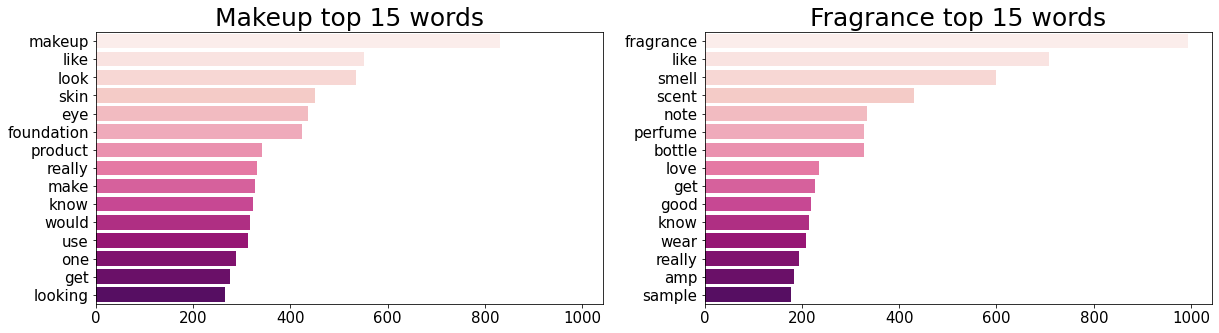

In [64]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,5))

axes[0].set_title('Makeup top 15 words',fontsize = 25)
axes[0].tick_params(labelsize=15)
sns.barplot(ax=axes[0],x =count_makeup, y =words_makeup, palette= 'RdPu');

axes[1].set_title('Fragrance top 15 words',fontsize = 25)
axes[1].tick_params(labelsize=15)
sns.barplot(ax=axes[1],x =count_frag, y =words_frag, palette= 'RdPu');

The graph above shows the same results when we plot the wordcloud. However, there results are different when we plot for phrases for each subreddit

In [65]:
# total words
print(f' Makeup has a total of {len(mword_freq)} words')
print(f' Fragrance has a total of {len(fword_freq)} words')

 Makeup has a total of 5634 words
 Fragrance has a total of 7213 words


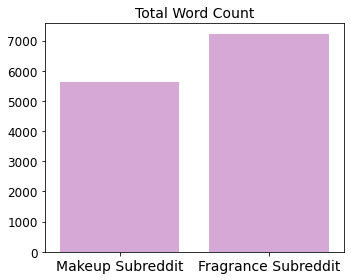

In [66]:
#visualisation for total words
plt.figure(figsize = (5,4))
sns.barplot(y = [(len(mword_freq)), (len(fword_freq))], 
            x = ['Makeup Subreddit','Fragrance Subreddit'] , color = 'plum')
plt.title('Total Word Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()

In [67]:
#unique words makeup reddit
makeup =[]

count_m = 0

for i in mword_freq:
    if i not in makeup:
        count_m +=1
        makeup.append(i)

In [68]:
#unique words fragrance reddit
frag =[]

count_f = 0

for i in fword_freq:
    if i not in frag:
        count_f +=1
        frag.append(i)

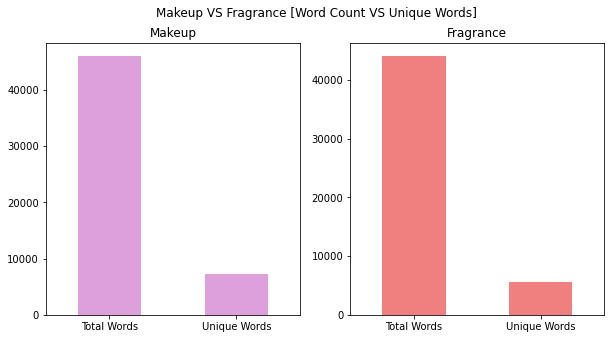

In [69]:
#compare the unique words in both subreddits

fig, axes = plt.subplots(1,2, sharex =True, figsize= (10,5))
fig.suptitle('Makeup VS Fragrance [Word Count VS Unique Words]')

axes[0].set_title('Makeup')
pd.Series([len(freqm_count),len(makeup)], index=['Total Words','Unique Words']).plot(ax=axes[1],rot=0,kind="bar",color = 'lightcoral')


axes[1].set_title('Fragrance')
pd.Series([len(freqf_count),len(frag)], index=['Total Words','Unique Words']).plot(ax=axes[0],rot=0,kind="bar",color = 'plum');

* Makeup has a slightly higher unique words

In [70]:
def Intersection(makeup, frag):
    return set(makeup).intersection(frag)

print(len(Intersection(freqm_count, freqf_count)))

2612


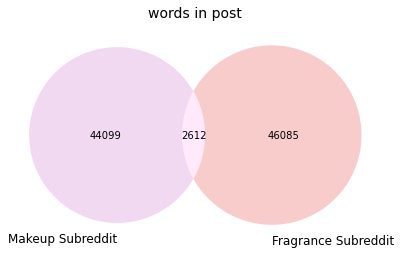

In [71]:
#Finding Common words
venn2(subsets = (len(freqm_count),len(freqf_count),len(Intersection(freqm_count, freqf_count))), 
      set_labels = ('Makeup Subreddit', 'Fragrance Subreddit'),set_colors = ('plum','lightcoral'))
plt.title('words in post', fontsize=14)
plt.tight_layout()

There are 2612 words that are common in both makeup and fragrance subreddit

# Summary of EDA

* Makeup has 44 099 words
* Fragrance has 46 085 words
* Common words: 2612
* Unique words: Makeup has just slightly more
* Top frequent words and phrases are different from each other
* Null Values were dropped as it is about 1% for either subreddit
* There is no imbalance data as the word count, words in post of each subreddit as well as percentage of text only posts are similar in number to each of the subreddit
* As we are dealing with NLP, we can rule out outliers as we are taking all the words to train our model

# Preparing the datasets for modelling

* keeping the lem column

In [72]:
df_makeup.head()

,subreddit,message,tokens,lem
0,Makeup,"gel eyeliner gets really messyhey, I’m fairly ...","[gel, eyeliner, gets, really, messyhey, fairly...","[gel, eyeliner, get, really, messyhey, fairly,..."
1,Makeup,Which Is The Best Brand For Makeup Kit?[removed],"[Which, Is, The, Best, Brand, For, Makeup, Kit...","[which, is, the, best, brand, for, makeup, kit..."
2,Makeup,Colorfix?Has anybody tried Danessa Myricks' Co...,"[Colorfix, Has, anybody, tried, Danessa, Myric...","[colorfix, has, anybody, tried, danessa, myric..."
3,Makeup,Are all micellar water products the same? How ...,"[Are, all, micellar, water, products, the, sam...","[are, all, micellar, water, product, the, same..."
4,Makeup,First Impression Reviews[Pictures are availabl...,"[First, Impression, Reviews, Pictures, are, av...","[first, impression, reviews, pictures, are, av..."


In [73]:
df_fragrance.head()

,subreddit,message,tokens,lem
0,fragrance,Valentino uomo intense edpHow many sprays of t...,"[Valentino, uomo, intense, edpHow, many, spray...","[valentino, uomo, intense, edphow, many, spray..."
1,fragrance,drybar noir scent?i am OBSESSED with the smell...,"[drybar, noir, scent, am, OBSESSED, with, the,...","[drybar, noir, scent, am, obsessed, with, the,..."
2,fragrance,What longevity do you expect from your perfume...,"[What, longevity, do, you, expect, from, your,...","[what, longevity, do, you, expect, from, your,..."
3,fragrance,Perfume Reccomendations?[removed],"[Perfume, Reccomendations, removed]","[perfume, reccomendations, removed]"
4,fragrance,Fragrance Wardrobe (36F)[removed],"[Fragrance, Wardrobe, 36F, removed]","[fragrance, wardrobe, 36f, removed]"


In [74]:
#Joining words back for each row in lem column
for i in df_fragrance['lem'].index:
    df_fragrance['lem'][i] = ' '.join(df_fragrance['lem'][i])

for i in df_makeup['lem'].index:
    df_makeup['lem'][i] = ' '.join(df_makeup['lem'][i])

In [75]:
df_makeup.head()

,subreddit,message,tokens,lem
0,Makeup,"gel eyeliner gets really messyhey, I’m fairly ...","[gel, eyeliner, gets, really, messyhey, fairly...",gel eyeliner get really messyhey fairly new to...
1,Makeup,Which Is The Best Brand For Makeup Kit?[removed],"[Which, Is, The, Best, Brand, For, Makeup, Kit...",which is the best brand for makeup kit removed
2,Makeup,Colorfix?Has anybody tried Danessa Myricks' Co...,"[Colorfix, Has, anybody, tried, Danessa, Myric...",colorfix has anybody tried danessa myricks col...
3,Makeup,Are all micellar water products the same? How ...,"[Are, all, micellar, water, products, the, sam...",are all micellar water product the same how do...
4,Makeup,First Impression Reviews[Pictures are availabl...,"[First, Impression, Reviews, Pictures, are, av...",first impression reviews pictures are availabl...


In [76]:
df_fragrance.head()

,subreddit,message,tokens,lem
0,fragrance,Valentino uomo intense edpHow many sprays of t...,"[Valentino, uomo, intense, edpHow, many, spray...",valentino uomo intense edphow many spray of th...
1,fragrance,drybar noir scent?i am OBSESSED with the smell...,"[drybar, noir, scent, am, OBSESSED, with, the,...",drybar noir scent am obsessed with the smell o...
2,fragrance,What longevity do you expect from your perfume...,"[What, longevity, do, you, expect, from, your,...",what longevity do you expect from your perfume...
3,fragrance,Perfume Reccomendations?[removed],"[Perfume, Reccomendations, removed]",perfume reccomendations removed
4,fragrance,Fragrance Wardrobe (36F)[removed],"[Fragrance, Wardrobe, 36F, removed]",fragrance wardrobe 36f removed


In [77]:
df_makeup.drop(['message', 'tokens'], axis=1, inplace=True)
df_fragrance.drop(['message', 'tokens'], axis=1, inplace=True)

In [78]:
df_makeup.head()

,subreddit,lem
0,Makeup,gel eyeliner get really messyhey fairly new to...
1,Makeup,which is the best brand for makeup kit removed
2,Makeup,colorfix has anybody tried danessa myricks col...
3,Makeup,are all micellar water product the same how do...
4,Makeup,first impression reviews pictures are availabl...


In [79]:
df_fragrance.head()

,subreddit,lem
0,fragrance,valentino uomo intense edphow many spray of th...
1,fragrance,drybar noir scent am obsessed with the smell o...
2,fragrance,what longevity do you expect from your perfume...
3,fragrance,perfume reccomendations removed
4,fragrance,fragrance wardrobe 36f removed


In [80]:
#Convert to CSV
df_makeup.to_csv('mkup.csv',index = False)
#Convert to CSV
df_fragrance.to_csv('frag.csv',index = False)